# This notebook is for the Fair-Shapely experiment

In [24]:
%reload_ext autoreload
%autoreload 2

### 1. Import libraries

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### 2. Import dataset

In [26]:
from src.data.unified_dataloader import load_dataset

a, processed_compas4race= load_dataset('compas4race')

In [27]:
processed_compas4race.head(3)

,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_F,c_charge_degree_M,type_of_assessment_Risk of Recidivism,score_text_High,score_text_Low,score_text_Medium,two_year_recid
0,1,-0.061334,1,-0.162011,-0.195526,-0.227625,-0.735792,1,0,1,0,1,0,1
1,1,-0.901239,1,-0.162011,-0.195526,1.703263,0.059694,1,0,1,0,1,0,1
2,1,-0.985229,1,-0.162011,1.785502,-0.227625,-0.536921,1,0,1,1,0,0,0


### 3. Split label/unlabel data, split train/test data.

In [28]:
'''COMPAS for race research'''
df = processed_compas4race.copy()
X = df.drop('two_year_recid', axis=1)
y = df['two_year_recid']


In [29]:
from src.evaluation.five_fold_cross_validation import evaluate_model
model = XGBClassifier()
evaluate_model(model=model, X_train=X, y_train=y, num_folds=5, dataset_name='compas4race')

-------------------------------------
-------------1th fold----------------
-------------------------------------
1. Split the compas4race dataset into majority group and minority group according to the number of sensitive attribute, besides split by label 0 and label 1
2. 初始化FairnessExplainer
--------接下来先对minority group进行修改--------
3(a). 将X_train_minority_label0与X_train_majority_label0进行匹配
3(b). 将X_train_minority_label1与X_train_majority_label1进行匹配
4(a). 使用FairSHAP, 从 X_train_majority_label0中找到合适的值替换X_train_minority_label0中的数据
4(b). 使用FairSHAP, 从 X_train_majority_label1中找到合适的值替换X_train_minority_label1中的数据
5. 计算出varphi和q
在X_train_minority中shapely value中大于0.1的值的个数有: 107
--------接下来对majority group进行修改--------
3(a). 将X_train_majority_label0与X_train_minority_label0进行匹配
3(b). 将X_train_majority_label1与X_train_minority_label1进行匹配
4(a). 使用fairshap, 从 X_train_minority_label0中找到合适的值替换X_train_majority_label0中的数据
4(b). 使用fairshap, 从 X_train_minority_label1中找到合适的值替换X_train_majority_label1中的数据
5. 计算出

### 4. read saved_csv file and make plots

In [2]:
def extract_original_values(fold):
    original_DR = fold.loc[0,'new_DR']
    original_DP = fold.loc[0,'new_DP']
    original_EO = fold.loc[0,'new_EO']
    original_PQP = fold.loc[0,'new_PQP']
    return original_DR, original_DP, original_EO, original_PQP

In [3]:
import numpy as np
import pandas as pd

fold1 = pd.read_csv('saved_results/compas4race/1-fold_results.csv')
fold2 = pd.read_csv('saved_results/compas4race/2-fold_results.csv')
fold3 = pd.read_csv('saved_results/compas4race/3-fold_results.csv')
fold4 = pd.read_csv('saved_results/compas4race/4-fold_results.csv')
fold5 = pd.read_csv('saved_results/compas4race/5-fold_results.csv')

fold1_original_DR, fold1_original_DP, fold1_original_EO, fold1_original_PQP = extract_original_values(fold1)
fold2_original_DR, fold2_original_DP, fold2_original_EO, fold2_original_PQP = extract_original_values(fold2)
fold3_original_DR, fold3_original_DP, fold3_original_EO, fold3_original_PQP = extract_original_values(fold3)
fold4_original_DR, fold4_original_DP, fold4_original_EO, fold4_original_PQP = extract_original_values(fold4)
fold5_original_DR, fold5_original_DP, fold5_original_EO, fold5_original_PQP = extract_original_values(fold5)

fold1.drop(fold1.index[0], inplace=True)
fold2.drop(fold2.index[0], inplace=True)
fold3.drop(fold3.index[0], inplace=True)
fold4.drop(fold4.index[0], inplace=True)
fold5.drop(fold5.index[0], inplace=True)

folds = [fold1, fold2, fold3, fold4, fold5]
original_drs = [fold1_original_DR, fold2_original_DR, fold3_original_DR, fold4_original_DR, fold5_original_DR]
original_dps = [fold1_original_DP, fold2_original_DP, fold3_original_DP, fold4_original_DP, fold5_original_DP]  
original_eos = [fold1_original_EO, fold2_original_EO, fold3_original_EO, fold4_original_EO, fold5_original_EO]
original_pqps = [fold1_original_PQP, fold2_original_PQP, fold3_original_PQP, fold4_original_PQP, fold5_original_PQP]


#### 4.1 直接plot_results

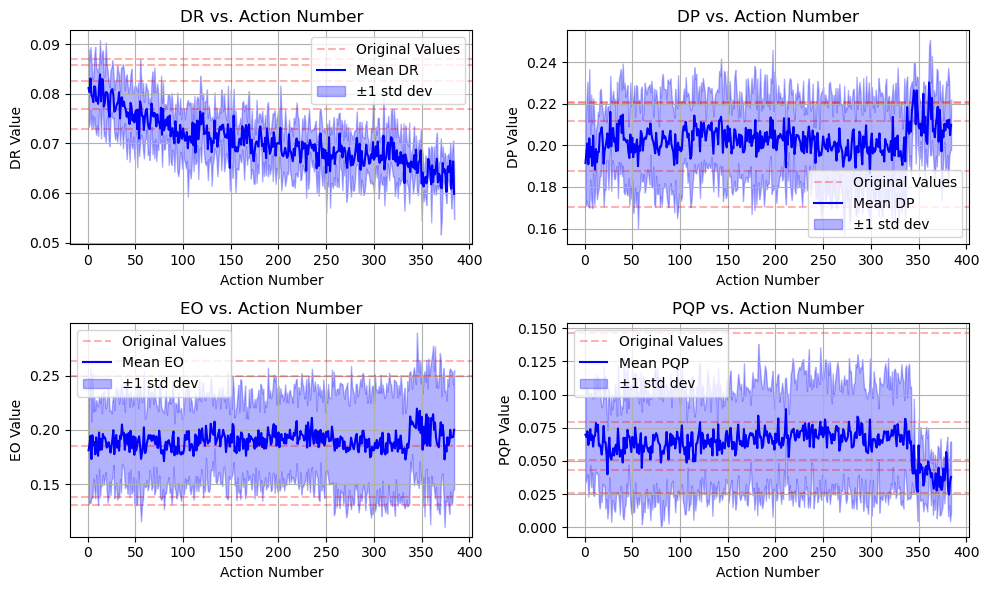

In [4]:
from src.visualization.visualization2 import plot_results

# 调用函数
plot_results(
    folds=folds,
    original_DR=original_drs, 
    original_DP=original_dps, 
    original_EO=original_eos, 
    original_PQP=original_pqps,
    stop_when_no_data=3,
    min_action=1,
    figsize=(10, 6),
    fill_alpha=0.3,
    fill_color='b',
    red_alpha=0.3  # 红线透明度
)

#### 4.2 画图每个fold相对自己original value的提升

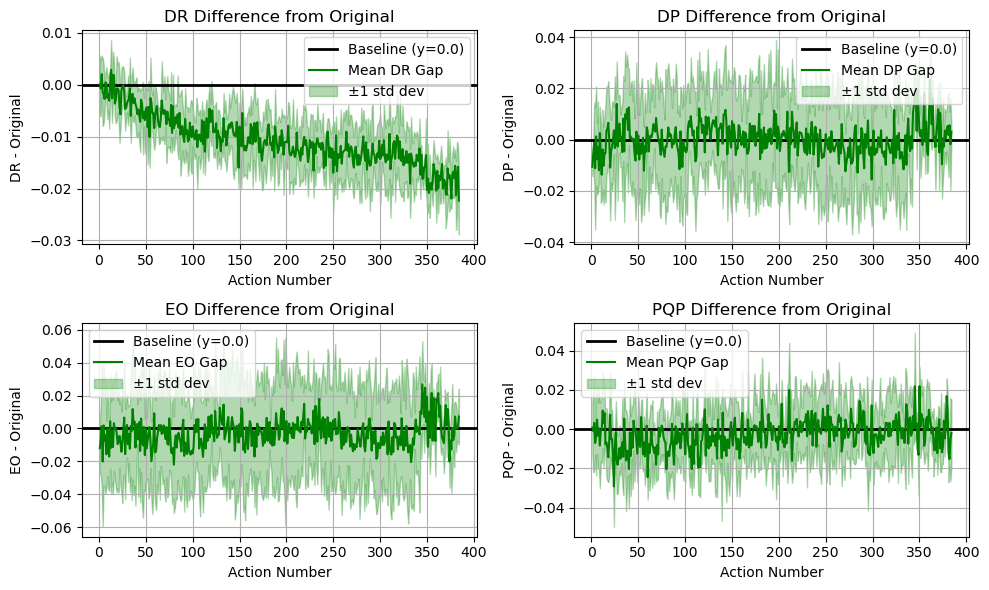

In [5]:
from src.visualization.visualization1 import plot_fairness_improvement


plot_fairness_improvement(
    folds=folds,
    original_DR=original_drs,
    original_DP=original_dps,
    original_EO=original_eos,
    original_PQP=original_pqps,
    stop_when_no_data=3,  # 当有 3 个 fold 无数据时停止
    min_action=1,
    baseline=0.0,
    figsize=(10, 6),
    fill_alpha=0.3,
    fill_color='g'
)